<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/33_4_Watermarked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание 2. На 4 балла:**
1. Используйте  изображения без водяных знаков из 3-й части урока (https://storage.yandexcloud.net/academy.ai/watermarked.zip)

2. Придумайте механизм нанесения водяных знаков (может быть обычный текст) на изображения. Нанесите водяные знаки на входные изображения.

3. Подумайте над архитектурой автокодировщика.

4. Размер картинок, число образцов для обучения выбирайте, исходя из ограничения среды выполнения, например,
ограничения ОЗУ бесплатного колаба.

5. Обучите модель и сделайте предсказания на контрольной выборке.

6. Продемонстрируйте работу модели путём вывода не менее 10 примеров из тестовой выборки, содержащих: исходное изображение, изображение с водяными знаками, предсказанное изображение и изображение шума (полученное путём вычитания предсказанного изображения из изображения).

Задание 3. На 5 баллов необходимо выполнить Задание 2 со следующими улучшениями:

1. Применить аугментацию к изображениям, не менее 5-ти модификаций (трансформаций) картинок.
2. Проведи пошаговое обучение (не менее 3-х шагов). Обучай модель в несколько итерации: загрузили часть данных, обучили на них, почистили ОЗУ, при необходимости скорректировали параметры обучения. Это позволит использовать оперативную память более эффективно и достигнуть лучшего обучения модели.

In [1]:
%%capture
!pip install keras

In [2]:
import numpy as np
from keras.models import Model
from keras import utils
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, UpSampling2D, Conv2DTranspose, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import cv2
import os
from keras.preprocessing.image import *
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!wget https://storage.yandexcloud.net/academy.ai/watermarked.zip
!unzip -qo "watermarked.zip" -d ./watermarked

--2025-01-02 10:12:05--  https://storage.yandexcloud.net/academy.ai/watermarked.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 731796045 (698M) [application/x-zip-compressed]
Saving to: ‘watermarked.zip’

watermarked.zip     100%[===================>] 697.89M  55.6MB/s    in 13s     

2025-01-02 10:12:18 (53.9 MB/s) - ‘watermarked.zip’ saved [731796045/731796045]



In [4]:
os.listdir('./watermarked/wm-nowm') # папки с изображениями

['train', 'valid']

In [5]:
train_path = './watermarked/wm-nowm/train' # тренировочные образцы
valid_path = './watermarked/wm-nowm/valid' # контрольные образцы

In [6]:
os.listdir(train_path)

['no-watermark', 'watermark']

In [7]:
os.listdir(valid_path)

['no-watermark', 'watermark']

In [8]:
train_path_no = os.path.join(train_path, 'no-watermark')
train_path_wm = os.path.join(train_path, 'watermark')
valid_path_no = os.path.join(valid_path, 'no-watermark')
valid_path_wm = os.path.join(valid_path, 'watermark')

In [9]:
train_nonwatermarked = [] # список файлов без водяных знаков (тренировочная выборка)
train_watermarked = []  # список файлов с водяными знаков (тренировочная выборка)
valid_nonwatermarked = [] # список файлов без водяных знаков (контрольная выборка)
valid_watermarked = [] # список файлов с водяными знаков (контрольная выборка)

# Обнаружено в датасете не соответствие, просто удалим файл
try:
    os.remove('./watermarked/wm-nowm/train/watermark/animal-dog-pet-cute.jpg')
except Exception as e:
    print(e) # вывод ошибки загрузки или масштабирования картинки

# Найдем парные файлы для тренировочной выборки
for file_no in sorted(os.listdir(train_path_no)):
    for file_wm in sorted(os.listdir(train_path_wm)):
        # Если имена файлов в обеих папках совпадают, то добавляем пути к этим файлам в списки
        if file_no == file_wm:
            train_nonwatermarked.append(os.path.join(train_path_no, file_no))
            train_watermarked.append(os.path.join(train_path_wm, file_wm))

# Найдем парные файлы для контрольной выборки
for file_no in sorted(os.listdir(valid_path_no)):
    for file_wm in sorted(os.listdir(valid_path_wm)):
        # Если имена файлов в обеих папках совпадают, то добавляем пути к этим файлам в списки
        if file_no == file_wm:
            valid_nonwatermarked.append(os.path.join(valid_path_no, file_no))
            valid_watermarked.append(os.path.join(valid_path_wm, file_wm))

In [10]:
print('Обучающая выборка содержит:')
print(len(train_nonwatermarked), 'файлов без водяных знаков')
print(len(train_watermarked), 'файлов с водяными знаками')

Обучающая выборка содержит:
1742 файлов без водяных знаков
1742 файлов с водяными знаками


In [11]:
print('Контрольная выборка содержит:')
print(len(valid_nonwatermarked), 'файлов без водяных знаков')
print(len(valid_watermarked), 'файлов с водяными знаками')

Контрольная выборка содержит:
107 файлов без водяных знаков
107 файлов с водяными знаками


In [12]:
width = 148
height = 148
dim = (width, height)

# Функция загрузки и масштабирования картинок
def createPixelArr(files):
    data = []
    for image in files: # цикл по каждой картинке в списке
        try:
            # Загрузим изображение в матрицу (сохранив цвета, загружает как BGR)
            img_arr = cv2.imread(image, cv2.IMREAD_COLOR)
            resized_arr = cv2.resize(img_arr, (width, height)) # масштабируем изображение
            data.append(resized_arr) # добавляем в список матрицу пикселей картинки
        except Exception as e:
            print(e) # вывод ошибки загрузки или масштабирования картинки
    return np.array(data) # возвращаем набор картинок как матрицу

In [13]:
position = (0, 200)

# Функция загрузки и масштабирования картинок + водяные знаки
def createPixelArr_add_watermarked(files):
    data = []
    for image in files:
        try:
            img_arr = cv2.imread(image, cv2.IMREAD_COLOR)  # Загрузим изображение в матрицу (сохранив цвета, загружает как BGR)
            new_arr = cv2.circle(img_arr, (150, 50), 20, (200, 0, 0), -1)  # Рисую красный круг
            new_arr_1 = cv2.putText(img_arr, "The Founder!", position, cv2.FONT_HERSHEY_SIMPLEX, 3, (150, 150, 150), 7)
            resized_arr = cv2.resize(new_arr_1, (width, height))
            data.append(resized_arr) # добавляем в список матрицу пикселей картинки
        except Exception as e:
            print(e) # вывод ошибки загрузки или масштабирования картинки
    return np.array(data) # возвращаем набор картинок как матрицу

In [14]:
y_train = createPixelArr(train_nonwatermarked) # подготовка картинок (без знаков, обучающая выборка)
X_train = createPixelArr_add_watermarked(train_nonwatermarked)    # подготовка картинок (водяные знаки, обучающая выборка)

y_test = createPixelArr(valid_nonwatermarked)  # подготовка картинок (без знаков, контрольная выборка)
X_test = createPixelArr_add_watermarked(train_nonwatermarked)     # подготовка картинок (водяные знаки, контрольная выборка)

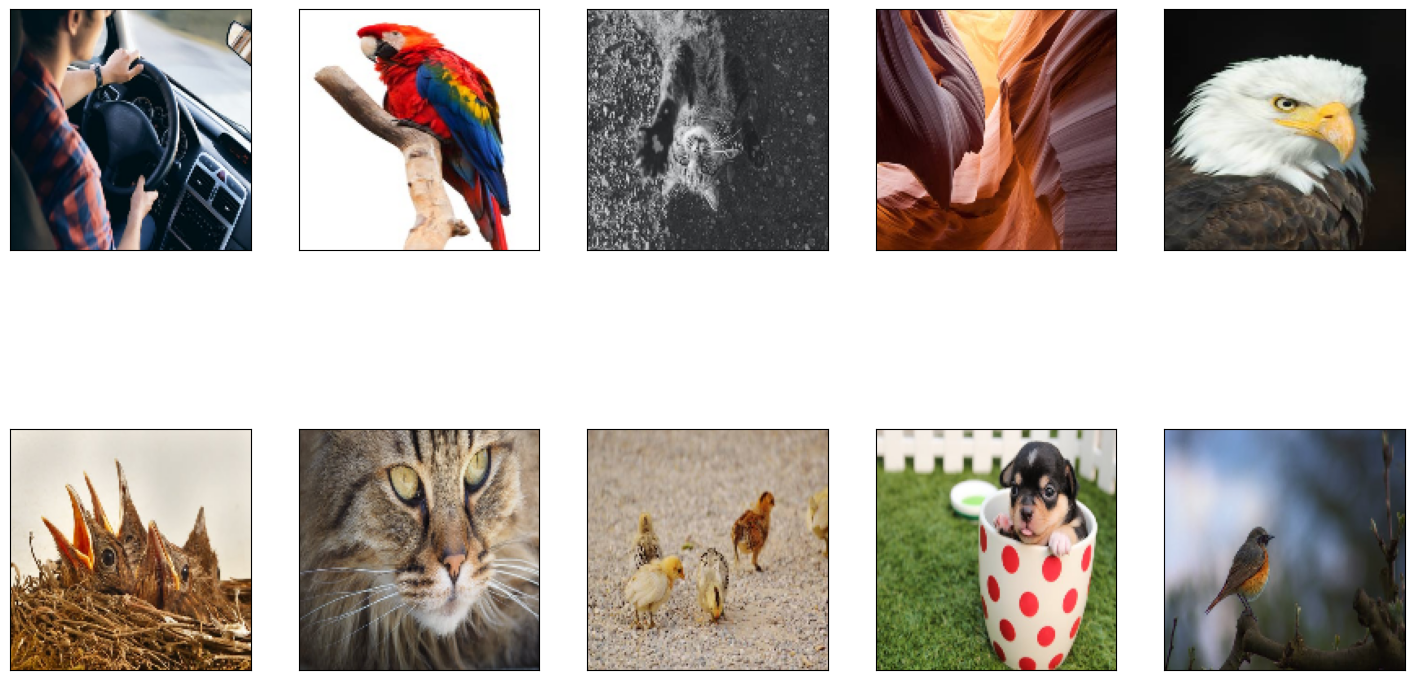

In [15]:
# ИСХОДНЫЕ ИЗОБРАЖЕНИЯ
plt.figure(figsize=(18, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(y_train[i], cv2.COLOR_BGR2RGB))
plt.show()

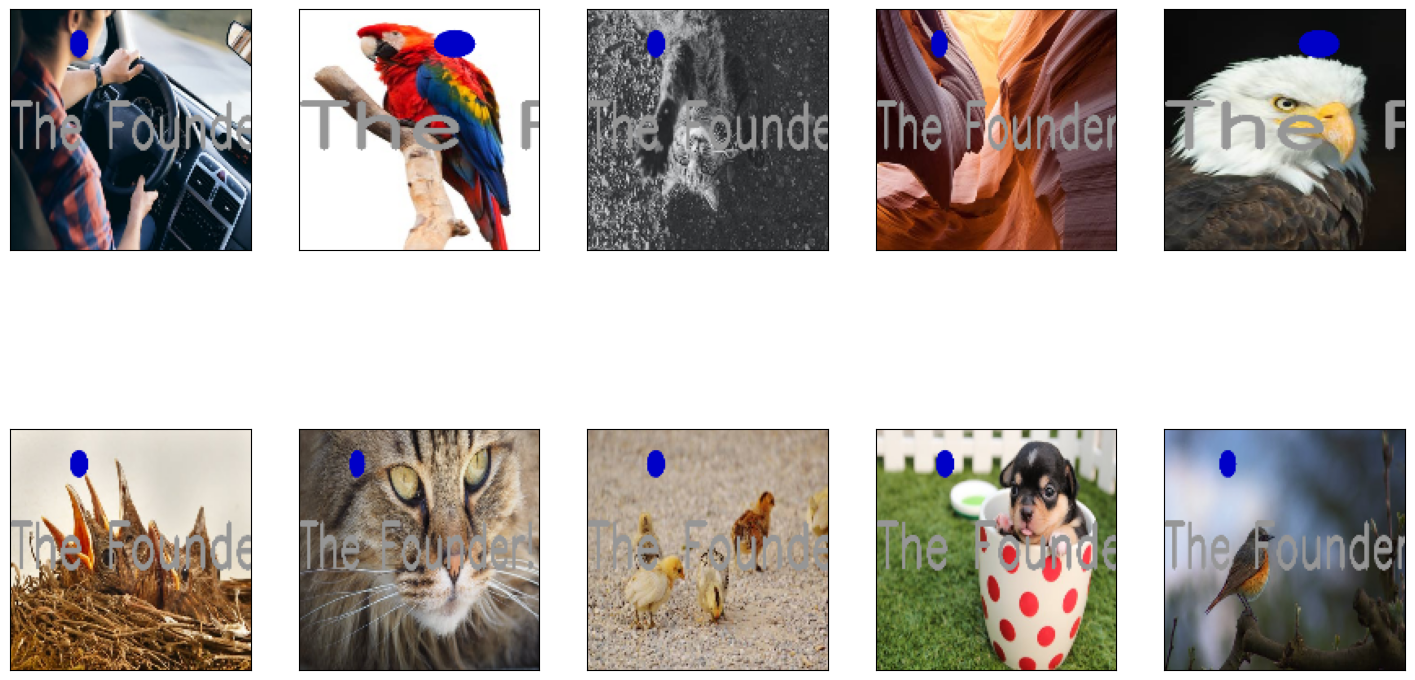

In [16]:
# ИСХОДНЫЕ ИЗОБРАЖЕНИЯ С ВОДЯНЫМИ ЗНАКАМИ
plt.figure(figsize=(18, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
train_nonwatermarked = None
train_watermarked    = None
valid_nonwatermarked = None
valid_watermarked    = None

In [18]:
# Функции аугментации изображений

def data_augmentation(inputImage): # функция прогоняет картинки через все методы аугментации
    return aug_5(aug_4(aug_3(randomContrast(randomBrightness(inputImage))))).numpy()

def randomBrightness(pic): # добавляем изображению случайную яркость от 1% до 20%
    return tf.image.random_brightness(pic, random.uniform(0.01, 0.4), 1)

def randomContrast(pic): # добавляем изображению случайную контрастность от 5% до 50%
    return tf.image.random_contrast(pic, 0.1, 0.7, 1)

def aug_3(pic):
    return tf.image.random_flip_up_down(pic)

def aug_4(pic):
    return tf.image.random_flip_left_right(pic)

def aug_5(pic):
    return tf.image.random_crop(value = pic, size=(148, 148, 3))

In [19]:
data_augmented_X = []
data_augmented_y = []

for image in X_train:
    data_augmented_X.append(data_augmentation(image))

for image in y_train:
    data_augmented_y.append(data_augmentation(image))

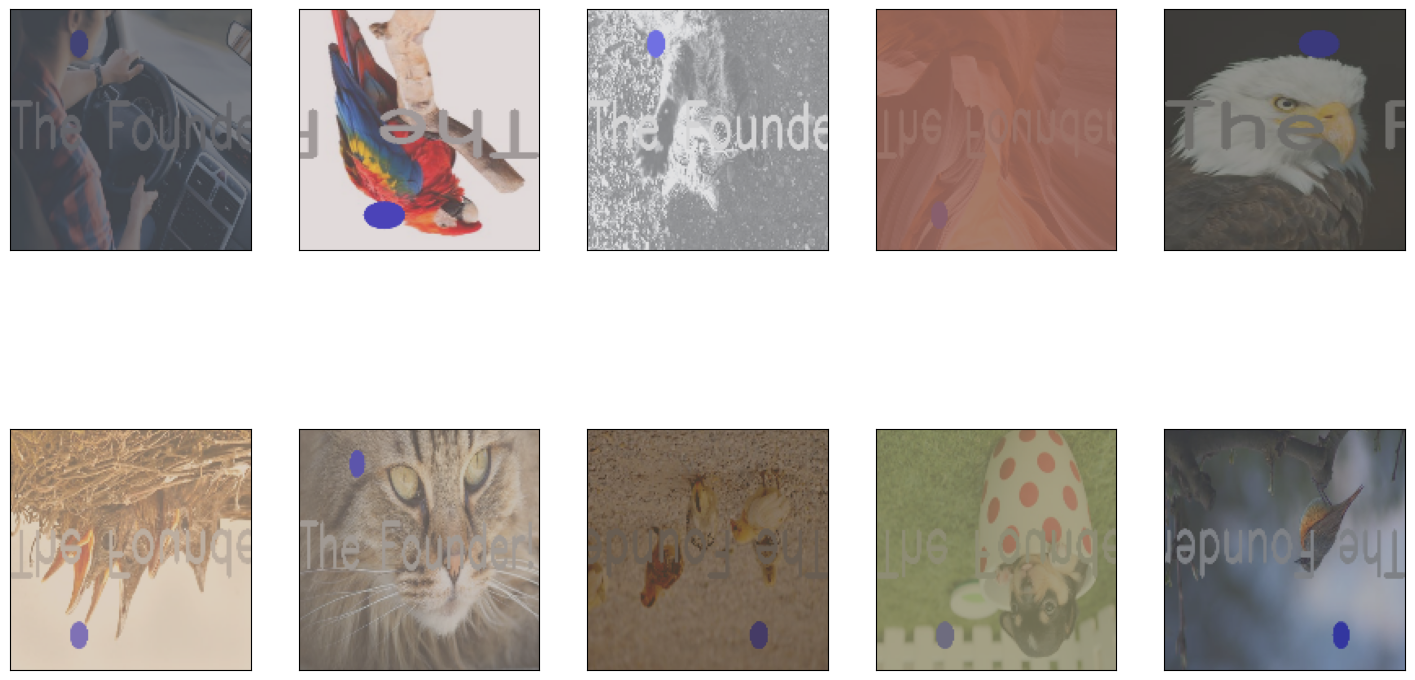

In [20]:
# ИСХОДНЫЕ ИЗОБРАЖЕНИЯ С ВОДЯНЫМИ ЗНАКАМИ + АУГМЕНТАЦИЯ
plt.figure(figsize=(18, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(data_augmented_X[i], cv2.COLOR_BGR2RGB))
plt.show()

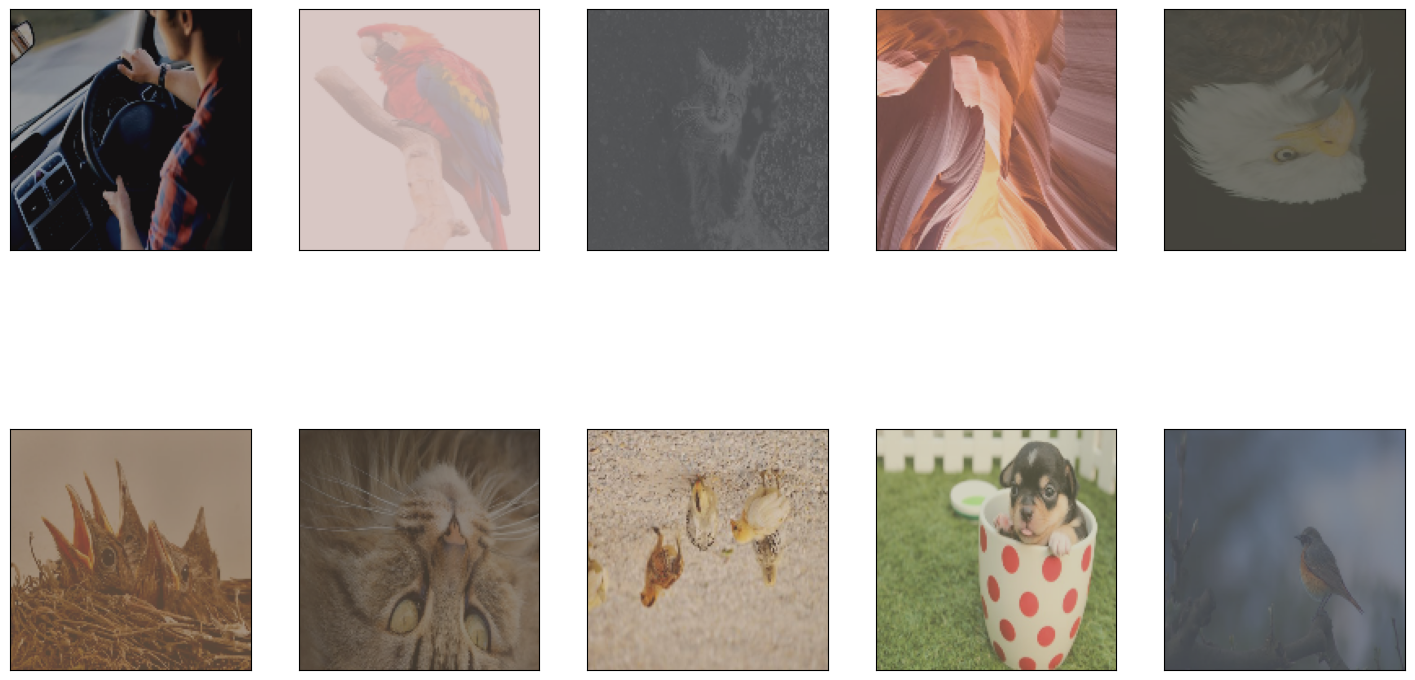

In [21]:
# ИСХОДНЫЕ ИЗОБРАЖЕНИЯ + АУГМЕНТАЦИЯ
plt.figure(figsize=(18, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(data_augmented_y[i], cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
X_train = np.append(X_train, data_augmented_X, axis=0)
y_train = np.append(y_train, data_augmented_y, axis=0)

In [23]:
X_train = X_train.astype('float32') / 255.
y_train = y_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

In [29]:
def create_model(img_x, img_y, channel):
    inputs = Input(shape=(img_x, img_y, channel))

    # Кодировщик - сжимает входные данные в латентное пространство
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    h = MaxPooling2D((2, 2), padding='same')(x)

    # Декодировщик - реконструирует сжатое представление
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(h)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)

    outputs = Conv2D(channel, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse',  metrics=['acc'])
    return model

In [30]:
watermark_auto_encoder = create_model(width, height, 3)

In [31]:
watermark_auto_encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 148, 148, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 148, 148, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 74, 74, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 74, 74, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 37, 37, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 37, 37, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 19, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 19, 19, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 19, 19, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 10, 10, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 20, 20, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 20, 20, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 38, 38, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 76, 76, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 74, 74, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 148, 148, 128)       │              

 Total params: 204,131 (797.39 KB)

 Trainable params: 203,683 (795.64 KB)

 Non-trainable params: 448 (1.75 KB)

Схема сверточного автокодировщика:


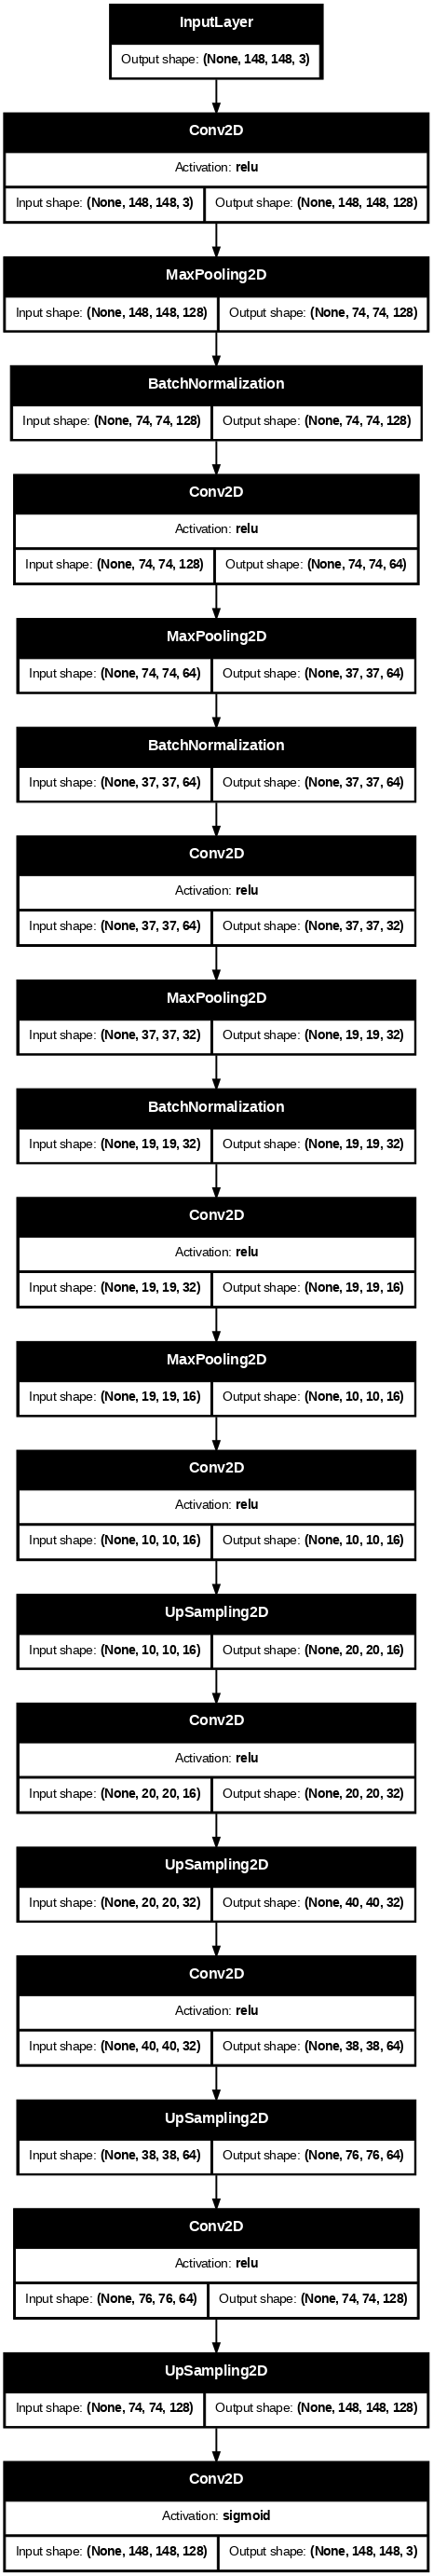

In [32]:
print('Схема сверточного автокодировщика:')
utils.plot_model(watermark_auto_encoder, show_shapes=True, dpi=70, show_layer_activations=True, expand_nested=True)

In [33]:
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

def plot_eval_epoch(epochs, batch_size):
    global history
    history = watermark_auto_encoder.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stop])

Epoch 1/3
109/109 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - acc: 0.4404 - loss: 0.0517
Epoch 2/3
109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - acc: 0.5821 - loss: 0.0323
Epoch 3/3
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - acc: 0.6006 - loss: 0.0313


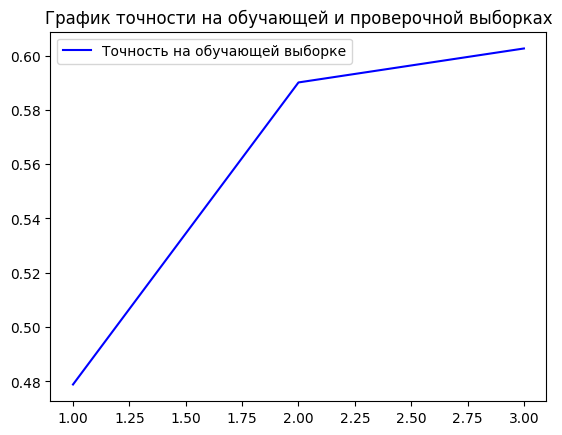

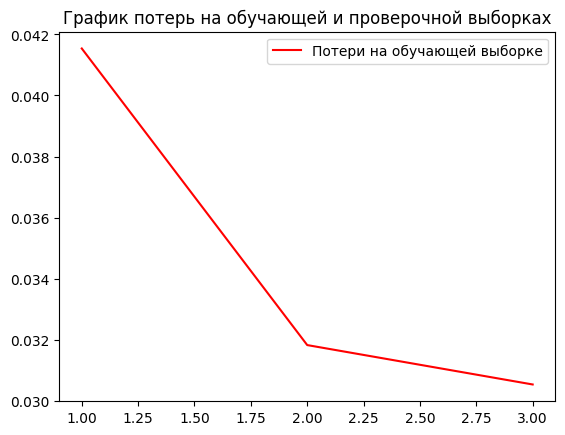

In [34]:
plot_eval_epoch(epochs=3, batch_size=32)

acc = history.history['acc']              # данные о точности на обучающей выборке
loss = history.history['loss']            # данные об ошибке на обучающей выборке
epochs = range(1, len(acc) + 1)           # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'b', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

In [ ]:
# early_stop = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
# history = watermark_auto_encoder.fit(X_train, y_train, batch_size=256, epochs=100, callbacks=[early_stop])

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 64s 869ms/step - acc: 0.3433 - loss: 0.0600
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 403ms/step - acc: 0.4249 - loss: 0.0357
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 413ms/step - acc: 0.5069 - loss: 0.0331
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 411ms/step - acc: 0.5977 - loss: 0.0314
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 410ms/step - acc: 0.6316 - loss: 0.0310
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step - acc: 0.6298 - loss: 0.0298
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 411ms/step - acc: 0.6367 - loss: 0.0306
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 412ms/step - acc: 0.6306 - loss: 0.0293
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 410ms/step - acc: 0.6439 - loss: 0.0287
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 411ms/step - acc: 0.6421 - loss: 0.0291
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 407ms/step - acc: 0.6479 - loss: 0.0283
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 412ms/step - acc: 0.6472 - loss: 0.0278
E

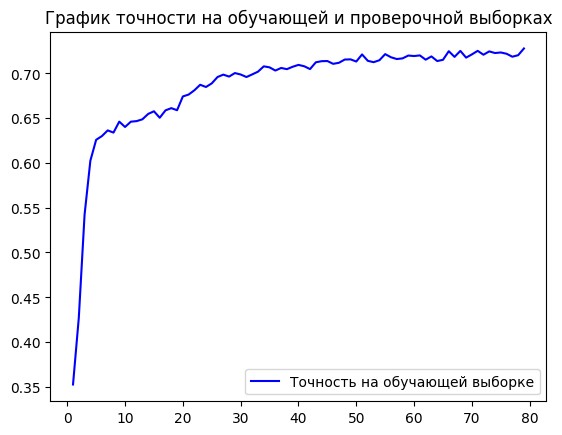

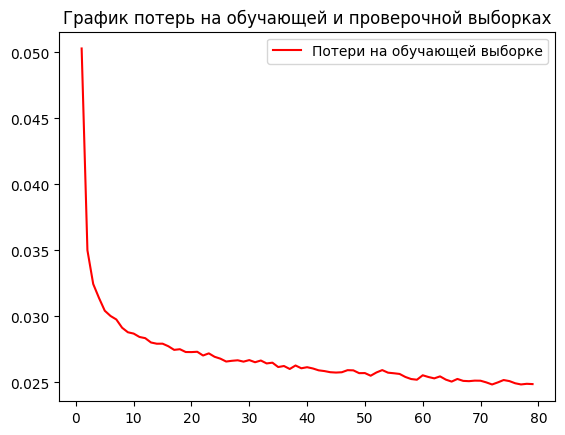

In [ ]:
# import matplotlib.pyplot as plt           # библиотека для рисования графиков
# acc = history.history['acc']              # данные о точности на обучающей выборке
# loss = history.history['loss']            # данные об ошибке на обучающей выборке
# epochs = range(1, len(acc) + 1)           # массив со значениями для оси абсцисс (Х)
# plt.plot(epochs, acc, 'b', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
# plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
# plt.legend()                                                               #  легенда графика
# plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
# plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
# plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
# plt.legend()                                                               #  легенда графика
# plt.show()                                                                 #  рисуем график

In [35]:
result = watermark_auto_encoder.predict(X_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step


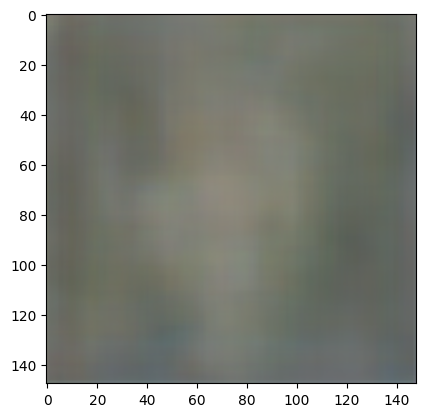

In [36]:
rnd = random.randint(0, 107)
plt.imshow(cv2.cvtColor(result[rnd], cv2.COLOR_BGR2RGB))

In [37]:
noise = X_test - result

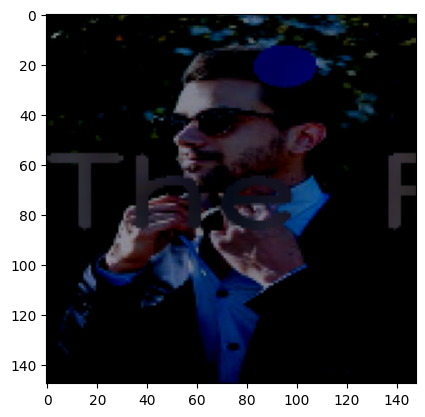

In [38]:
plt.imshow(cv2.cvtColor(noise[rnd], cv2.COLOR_BGR2RGB))

Epoch 1/6
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - acc: 0.6209 - loss: 0.0293
Epoch 2/6
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - acc: 0.6241 - loss: 0.0291
Epoch 3/6
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - acc: 0.6352 - loss: 0.0277
Epoch 4/6
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - acc: 0.6326 - loss: 0.0288
Epoch 5/6
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - acc: 0.6436 - loss: 0.0279
Epoch 6/6
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - acc: 0.6411 - loss: 0.0277


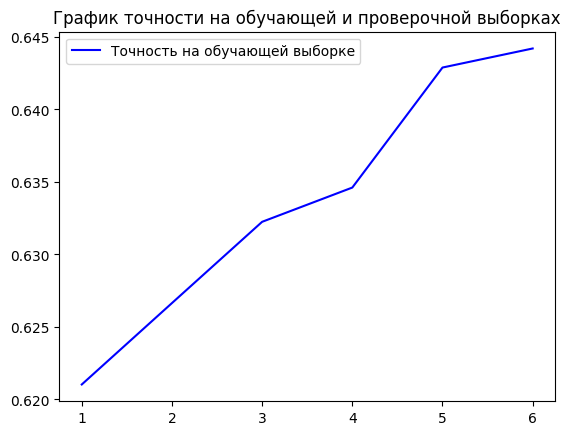

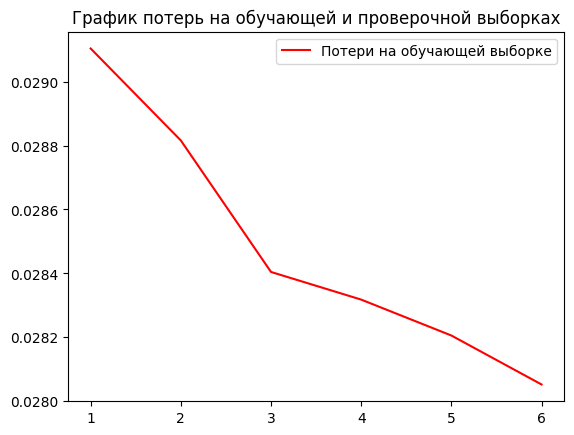

In [39]:
plot_eval_epoch(epochs=6, batch_size=64)

acc = history.history['acc']              # данные о точности на обучающей выборке
loss = history.history['loss']            # данные об ошибке на обучающей выборке
epochs = range(1, len(acc) + 1)           # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'b', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

In [40]:
result = watermark_auto_encoder.predict(X_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


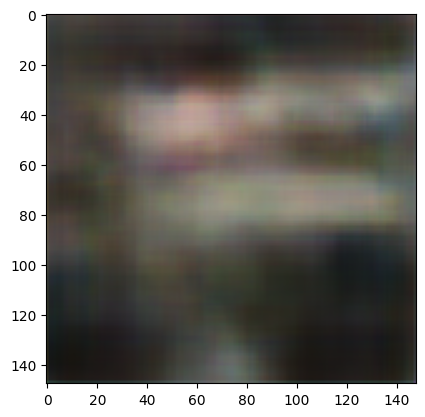

In [41]:
rnd = random.randint(0, 107)
plt.imshow(cv2.cvtColor(result[rnd], cv2.COLOR_BGR2RGB))

In [42]:
noise = X_test - result

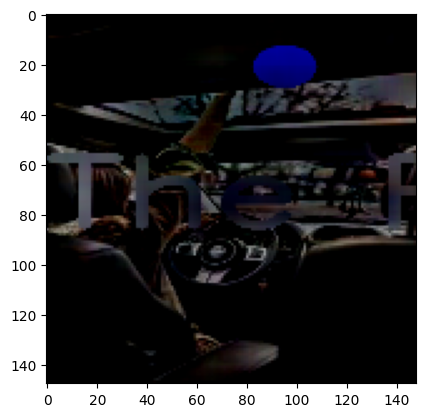

In [43]:
plt.imshow(cv2.cvtColor(noise[rnd], cv2.COLOR_BGR2RGB))

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - acc: 0.6495 - loss: 0.0275
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 326ms/step - acc: 0.6577 - loss: 0.0271
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 335ms/step - acc: 0.6648 - loss: 0.0274
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step - acc: 0.6707 - loss: 0.0267
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - acc: 0.6635 - loss: 0.0269
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 337ms/step - acc: 0.6658 - loss: 0.0273
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 328ms/step - acc: 0.6798 - loss: 0.0266
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - acc: 0.6731 - loss: 0.0271
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 341ms/step - acc: 0.6829 - loss: 0.0271
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 336ms/step - acc: 0.6778 - loss: 0.0263


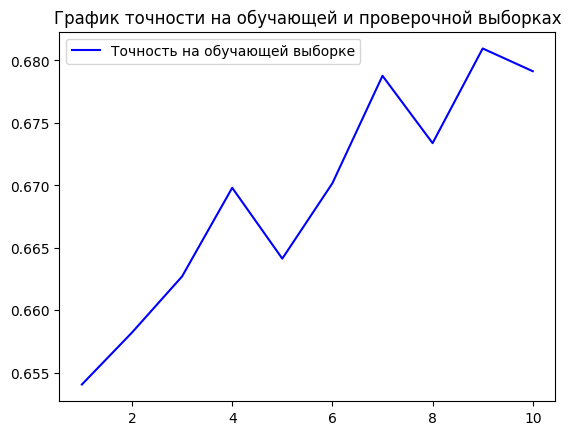

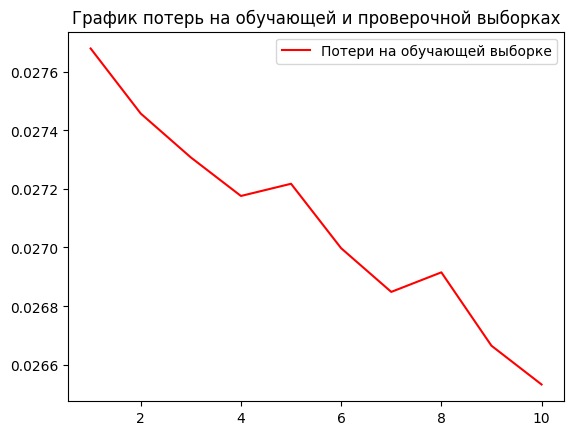

In [44]:
plot_eval_epoch(epochs=10, batch_size=100)

acc = history.history['acc']              # данные о точности на обучающей выборке
loss = history.history['loss']            # данные об ошибке на обучающей выборке
epochs = range(1, len(acc) + 1)           # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'b', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

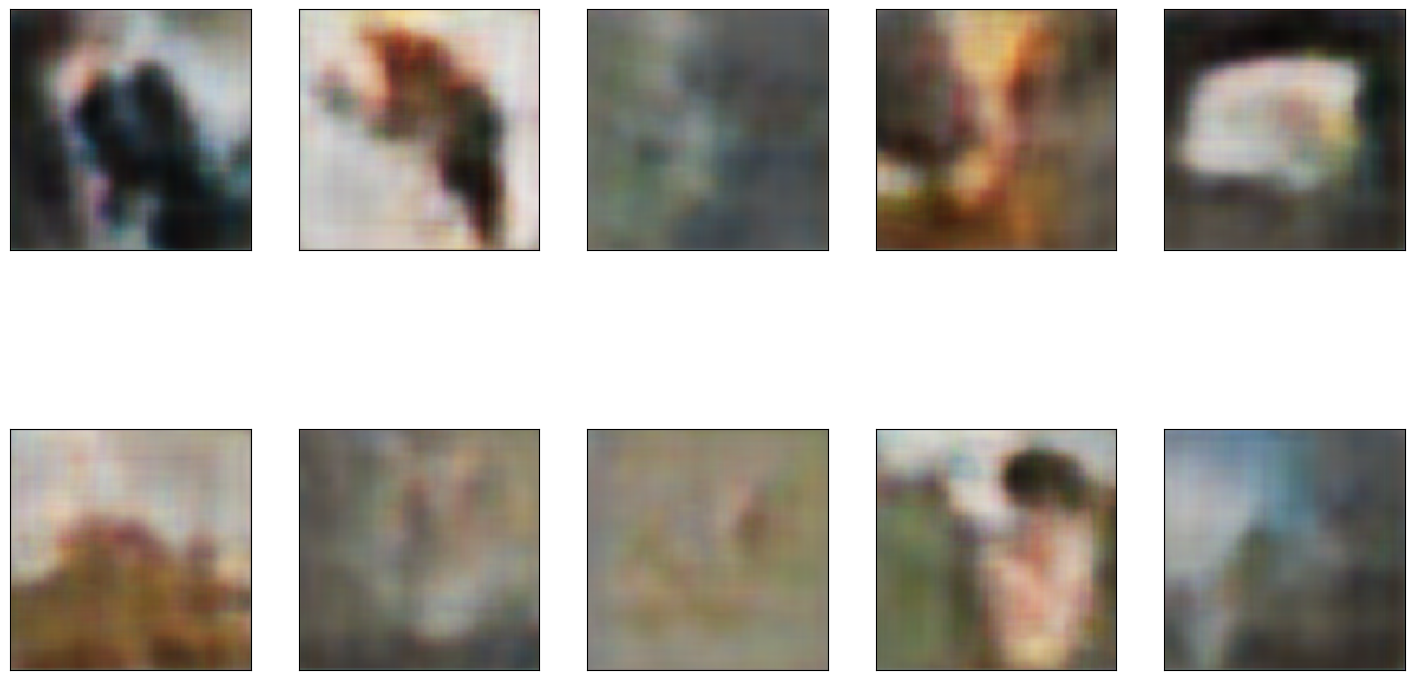

In [45]:
# ИСХОДНЫЕ ИЗОБРАЖЕНИЯ ПОСЛЕ АВТОКОДИРОВЩИКА
plt.figure(figsize=(18, 10))
for i in range(10):
    plt.subplot(2, 5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(result[i], cv2.COLOR_BGR2RGB))
plt.show()

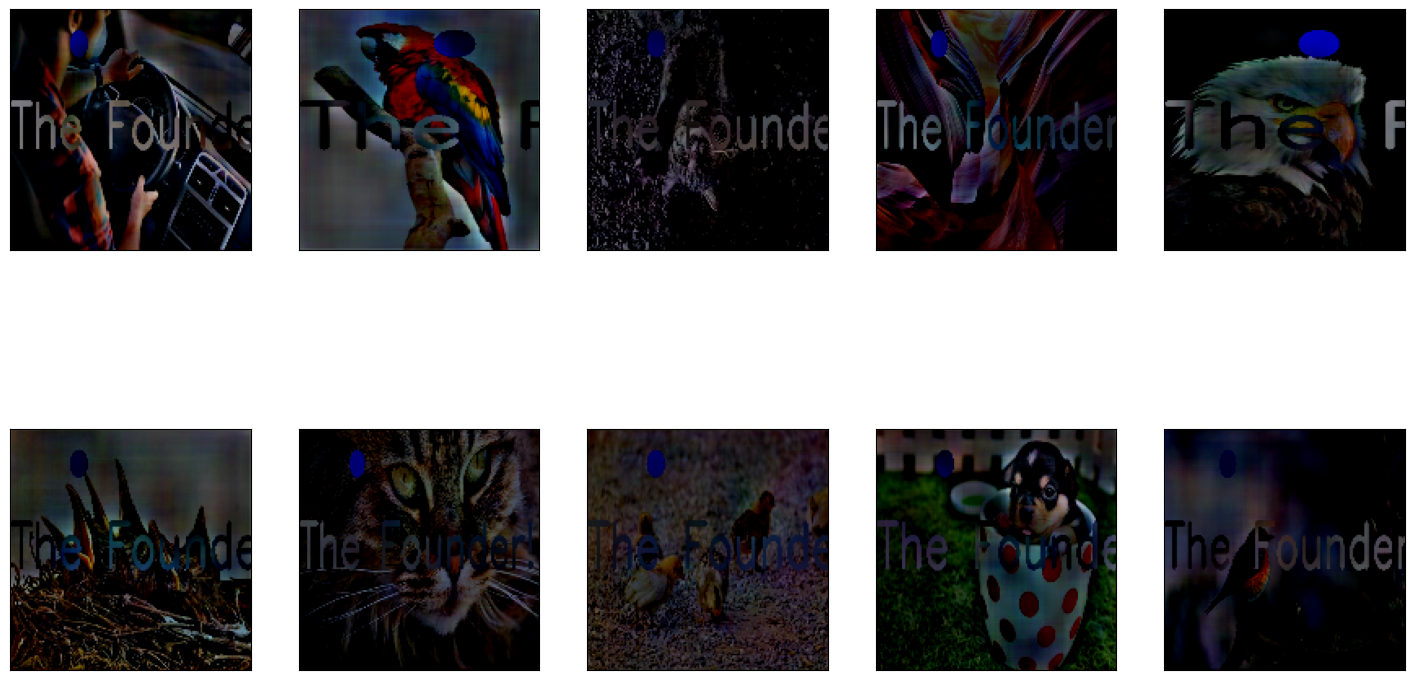

In [46]:
# ШУМ
plt.figure(figsize=(18, 10))
for i in range(10):
    plt.subplot(2, 5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(noise[i], cv2.COLOR_BGR2RGB))
plt.show()